# Overvies of needed libraries and modules

- The main framework for working with graphs and predictions on them is [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/). It contains various methods for Deep Learning on graphs. 
- Torch is essential for Graph neural netowrks. We can use activation functions, normalization methods, 'Sequential' to stack layers from there.
- Sklearn can be used for metrics computing and for simple models applying (like PCA for plotting weights of models).
- Netoworkx and matplotlip will be used for data visualization.

In [ ]:
!pip install torch_geometric
import matplotlib.pyplot as plt
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.3/repo.html
!pip install torch torchvision torchaudio


Looking in links: https://data.dgl.ai/wheels/torch-2.3/repo.html


In [2]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.datasets import Planetoid, CoraFull
from torch_geometric.nn import GCNConv, GATConv
from sklearn.metrics import accuracy_score
import random
import numpy as np


In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


# Dataset Loading
Pytorch Geometric has a separate module for datasets. There are several common datasets for GNNs: KarateClub (social network of a university karate club, contains 34 club members (nodes) and a record of who socialized with whom outside of the class (edges) right before the formal split of the club), TUDataset (a collection of benchmark datasets for graph classification and regression), Planetoid that will be used int his notebook.

`Cora` - one of the citation network datasets from Planetoid. It is a network of 2,708 machine-learning papers, organized into seven distinct classes. These papers are interlinked by 5,429 citations, forming a directed graph that maps out how papers cite each other. Feature vector of each paper is represented by a binary word vector (001001...), derived from a dictionary of 1,433 unique words, indicating the **presence or absence** of specific words in the paper. It can be applied in a wide range of tasks in terms of GNNs:
- Node classification: prediction of a node's class (paper theme)
- Link prediction: determine wheter there might be a connection between 2 nodes
- Clustering: combine nodes into groups with similar properties.

Cora's labels:

| Class name  | Number of Nodes   | Label   | 
|---|---|---|
| Neural Networks  | 818   | 3   |  
| Probabilistic Methods  | 426   |4   | 
|  Genetic Algorithm | 418  | 2  |  
| Theory | 351 | 7|
|Case Based|298|1|
|Reinforcement Learning|217|5|
|Rule Learning|180|6|




In [4]:
dataset_full = CoraFull(root='./CoraFull')

In [5]:
data_full = dataset_full[0]

In [26]:
from torch_geometric.datasets import Planetoid

# Load the Citeseer dataset using PyG
dataset = Planetoid(root='./CiteseerData', name='Citeseer')
data = dataset[0]
print(f"Dataset: {dataset}, Number of nodes: {data.num_nodes}, Number of edges: {data.num_edges}")


Processing...


Dataset: Citeseer(), Number of nodes: 3327, Number of edges: 9104


Done!


In [27]:
data.x.shape

torch.Size([3327, 3703])

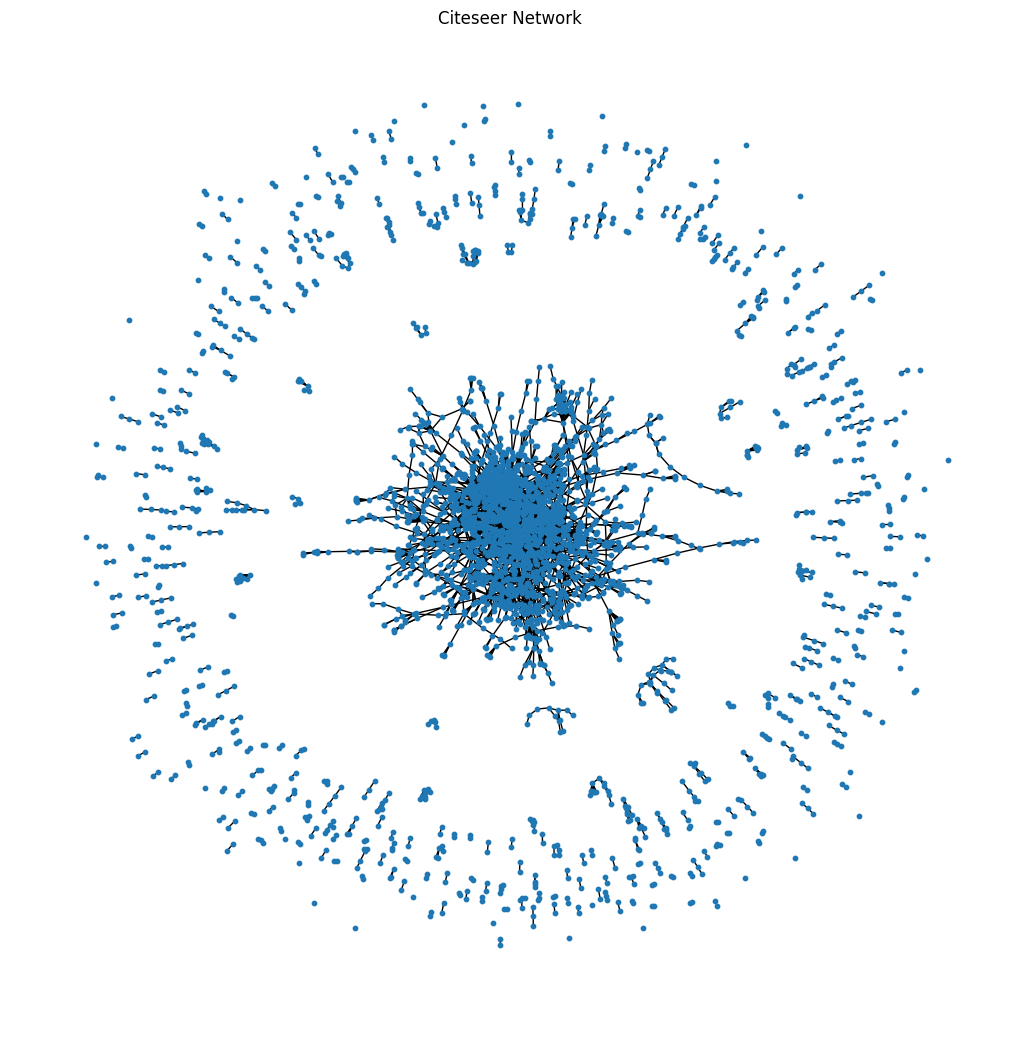

In [40]:
import networkx as nx
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(10, 10))
nx.draw(G, node_size=10)
plt.title("Citeseer Network")
plt.show()

Cora dataset can be organized from other packages since it is widely used:

In [29]:
# # Using DGL
# from dgl.data import CoraGraphDataset
# dataset = CoraGraphDataset()
# graph = dataset[0]

# # Create network yourself via pandas and networkx (or tensorflow)
# import networkx as nx
# import pandas as pd
# edges = pd.read_csv('cora.cites', sep='\t', header=None, names=['target', 'source'])
# nodes = pd.read_csv('cora.content', sep='\t', header=None)
# G = nx.from_pandas_edgelist(edges, 'source', 'target', create_using=nx.DiGraph())
# for i, row in nodes.iterrows():
#     G.nodes[row[0]].update({'feature': row[1:-1].values, 'label': row[-1]})

# Models

In [30]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [31]:
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=8):
        super(GAT, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads)
        self.gat2 = GATConv(hidden_dim * heads, output_dim, heads=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.gat1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.gat2(x, edge_index)
        return F.log_softmax(x, dim=1)


# Training and Evaluation

In [32]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

labels = data.y.cpu().numpy()
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float, device=device)



def train(model, data, optimizer, epochs=200):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask], weight=class_weights)
        loss.backward()
        optimizer.step()

        if epoch % 20 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


In [33]:
@torch.no_grad()
def evaluate(model, data):
    model.eval()
    logits = model(data)
    pred = logits.argmax(dim=1)
    acc_train = accuracy_score(data.y[data.train_mask].cpu(), pred[data.train_mask].cpu())
    acc_val = accuracy_score(data.y[data.val_mask].cpu(), pred[data.val_mask].cpu())
    acc_test = accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())
    return acc_train, acc_val, acc_test


# Pipeline

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# GCN
gcn = GCN(input_dim=dataset.num_features, hidden_dim=16, output_dim=dataset.num_classes).to(device)
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)

print("Training GCN...")
train(gcn, data, optimizer)
gcn_acc = evaluate(gcn, data)
print(f"GCN Accuracy - Train: {gcn_acc[0]:.4f}, Val: {gcn_acc[1]:.4f}, Test: {gcn_acc[2]:.4f}")

# GAT
gat = GAT(input_dim=dataset.num_features, hidden_dim=8, output_dim=dataset.num_classes, heads=8).to(device)
optimizer = torch.optim.Adam(gat.parameters(), lr=0.01, weight_decay=5e-4)

print("Training GAT...")
train(gat, data, optimizer)
gat_acc = evaluate(gat, data)
print(f"GAT Accuracy - Train: {gat_acc[0]:.4f}, Val: {gat_acc[1]:.4f}, Test: {gat_acc[2]:.4f}")

# Comparison
if gat_acc[2] > gcn_acc[2]:
    print("GAT outperformed GCN.")
else:
    print("GCN outperformed GAT.")


Training GCN...
Epoch 0, Loss: 1.7928
Epoch 20, Loss: 0.1016
Epoch 40, Loss: 0.0359
Epoch 60, Loss: 0.0393
Epoch 80, Loss: 0.0346
Epoch 100, Loss: 0.0408
Epoch 120, Loss: 0.0646
Epoch 140, Loss: 0.0456
Epoch 160, Loss: 0.0331
Epoch 180, Loss: 0.0149
GCN Accuracy - Train: 1.0000, Val: 0.6600, Test: 0.6740
Training GAT...
Epoch 0, Loss: 1.8050
Epoch 20, Loss: 0.0022
Epoch 40, Loss: 0.0037
Epoch 60, Loss: 0.0068
Epoch 80, Loss: 0.0065
Epoch 100, Loss: 0.0050
Epoch 120, Loss: 0.0120
Epoch 140, Loss: 0.0041
Epoch 160, Loss: 0.0052
Epoch 180, Loss: 0.0051
GAT Accuracy - Train: 1.0000, Val: 0.6540, Test: 0.6540
GCN outperformed GAT.


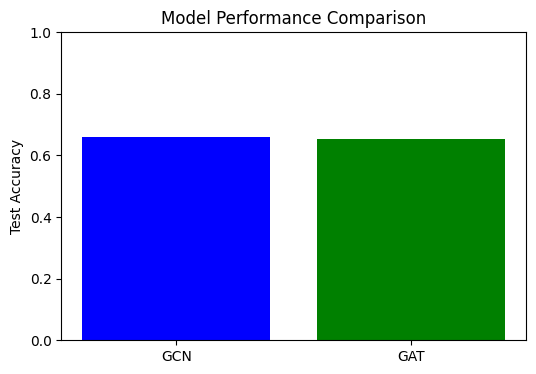

In [42]:
# Performance Comparison
import matplotlib.pyplot as plt

# Compare GCN and GAT accuracy
plt.figure(figsize=(6, 4))
plt.bar(["GCN", "GAT"], [gcn_acc[1], gat_acc[1]], color=['blue', 'green'])
plt.ylabel("Test Accuracy")
plt.title("Model Performance Comparison")
plt.ylim(0, 1)
plt.show()


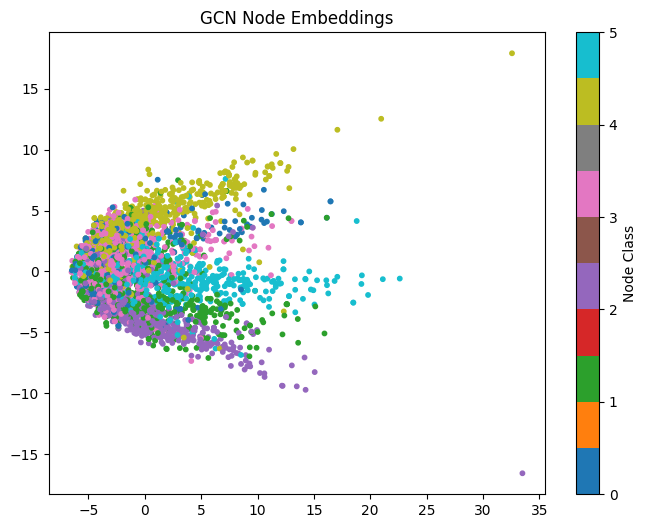

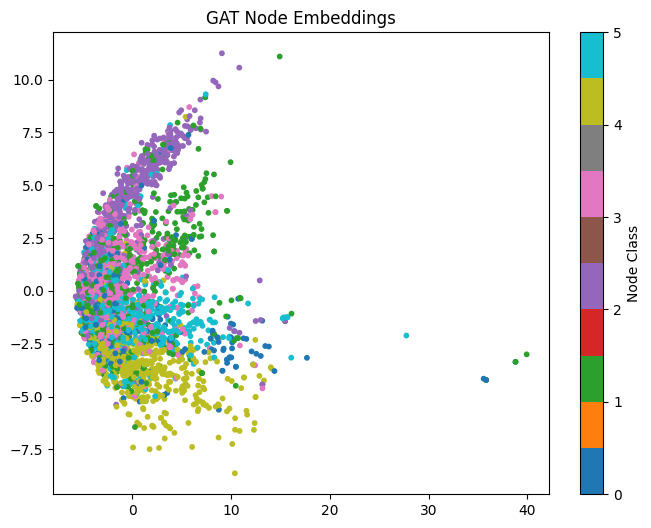

In [ ]:
from sklearn.decomposition import PCA

def visualize_embeddings(model, data, title):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        embeddings = logits.cpu().numpy()

    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=data.y.cpu().numpy(), cmap="tab10", s=10)
    plt.colorbar(scatter, label="Node Class")
    plt.title(title)
    plt.show()

visualize_embeddings(gcn, data, "GCN Node Embeddings")
visualize_embeddings(gat, data, "GAT Node Embeddings")


Epoch 0, Loss: 1.7875
Epoch 20, Loss: 0.0904
Epoch 40, Loss: 0.0248
Epoch 60, Loss: 0.0607
Epoch 80, Loss: 0.0553
Epoch 100, Loss: 0.0363
Epoch 120, Loss: 0.0427
Epoch 140, Loss: 0.0222
Epoch 160, Loss: 0.0459
Epoch 180, Loss: 0.0241
Epoch 0, Loss: 1.8086
Epoch 20, Loss: 0.0011
Epoch 40, Loss: 0.0196
Epoch 60, Loss: 0.0055
Epoch 80, Loss: 0.0063
Epoch 100, Loss: 0.0060
Epoch 120, Loss: 0.0061
Epoch 140, Loss: 0.0045
Epoch 160, Loss: 0.0044
Epoch 180, Loss: 0.0040


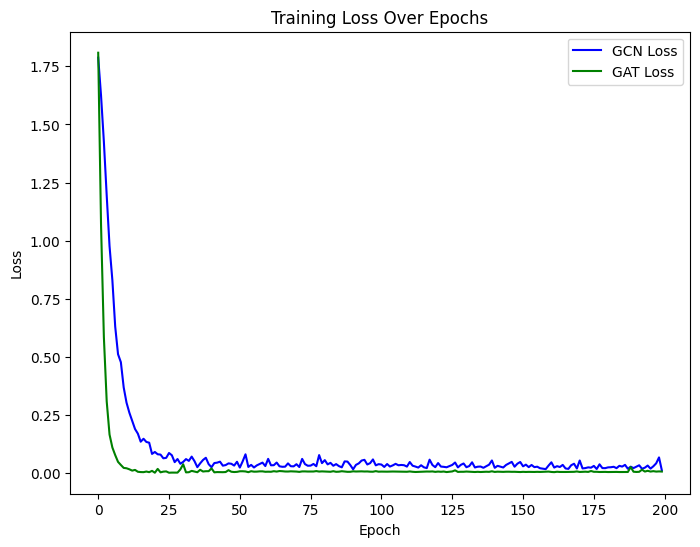

In [44]:
def train_with_loss_tracking(model, data, optimizer, epochs=200):
    model.train()
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 20 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    return losses

gcn = GCN(data.num_features, 16, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
gcn_losses = train_with_loss_tracking(gcn, data, optimizer)

gat = GAT(data.num_features, 8, dataset.num_classes, heads=8).to(device)
optimizer = torch.optim.Adam(gat.parameters(), lr=0.01, weight_decay=5e-4)
gat_losses = train_with_loss_tracking(gat, data, optimizer)

plt.figure(figsize=(8, 6))
plt.plot(gcn_losses, label="GCN Loss", color="blue")
plt.plot(gat_losses, label="GAT Loss", color="green")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()


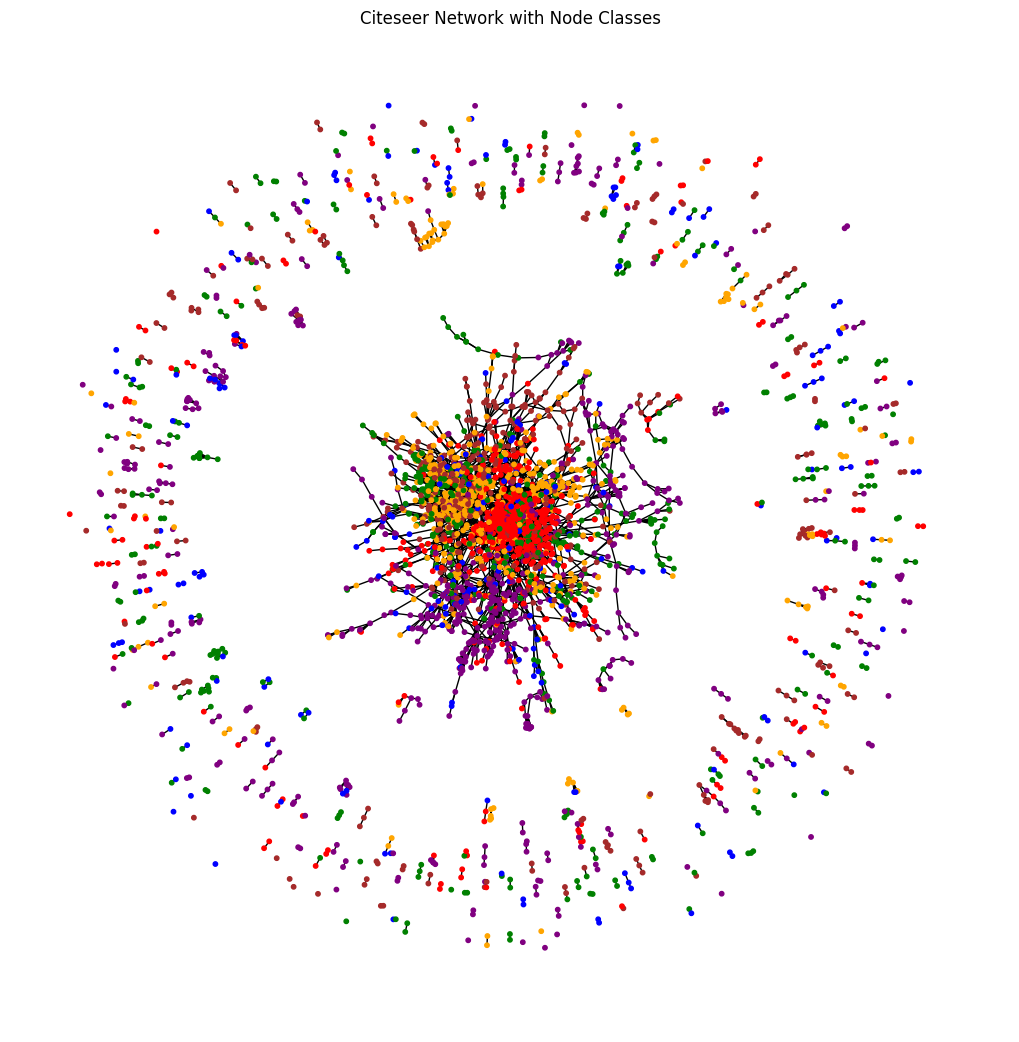

In [47]:
from torch_geometric.utils import to_networkx
import networkx as nx

color_map = ['blue', 'green', 'red']
G = to_networkx(data, to_undirected=True)
node_colors = [color_map[label] for label in data.y.cpu().numpy()]

plt.figure(figsize=(10, 10))
nx.draw(G, node_color=node_colors, node_size=10)
plt.title("Citeseer Network with Node Classes")
plt.show()


# Boosting

In [37]:
# class BoostedGNN:
#     def __init__(self, base_model_class, input_dim, hidden_dim, output_dim, n_estimators, data, lr=0.01):
#         self.models = []
#         self.alphas = []
#         self.data = data
#         self.n_estimators = n_estimators
#         self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#         # Initialize models and optimizers
#         for _ in range(n_estimators):
#             model = base_model_class(input_dim, hidden_dim, output_dim).to(self.device)
#             optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
#             self.models.append((model, optimizer))

#     def train(self):
#         # Initialize weights for each node
#         weights = torch.ones(self.data.num_nodes, dtype=torch.float, device=self.device)

#         for i, (model, optimizer) in enumerate(self.models):
#             print(f"Training Model {i + 1}...")
#             train_boosted_model(model, self.data, weights, optimizer)

#             # Evaluate model and calculate alpha
#             model.eval()
#             out = model(self.data)
#             pred = out.argmax(dim=1)
#             incorrect = (pred[self.data.train_mask] != self.data.y[self.data.train_mask])
#             err = torch.sum(weights[self.data.train_mask] * incorrect.float()) / torch.sum(weights[self.data.train_mask])
            
#             # Compute model weight (alpha)
#             alpha = 0.5 * torch.log((1 - err) / (err + 1e-10))
#             self.alphas.append(alpha.item())

#             # Update node weights
#             weights[self.data.train_mask] *= torch.exp(alpha * incorrect.float())
#             weights[self.data.train_mask] /= torch.sum(weights[self.data.train_mask])

#     @torch.no_grad()
#     def predict(self):
#         final_scores = torch.zeros((self.data.num_nodes, 7), device=self.device)
#         for model, alpha in zip(self.models, self.alphas):
#             logits = model[0](self.data)
#             final_scores += alpha * logits
#         return final_scores.argmax(dim=1)
    

In [38]:
# def train_boosted_model(model, data, weights, optimizer, epochs=50):
#     for epoch in range(epochs):
#         model.train()
#         optimizer.zero_grad()
#         out = model(data)
        
#         # Compute weighted loss manually
#         log_probs = out[data.train_mask]
#         targets = data.y[data.train_mask]
#         loss = -torch.sum(weights[data.train_mask] * log_probs[torch.arange(len(targets)), targets]) / torch.sum(weights[data.train_mask])
        
#         loss.backward()
#         optimizer.step()


In [39]:
# # Boosted GCN
# boosted_gcn = BoostedGNN(GCN, input_dim=dataset.num_features, hidden_dim=16, output_dim=dataset.num_classes, n_estimators=5, data=data)
# boosted_gcn.train()
# boosted_gcn_pred = boosted_gcn.predict()
# boosted_gcn_acc = accuracy_score(data.y[data.test_mask].cpu(), boosted_gcn_pred[data.test_mask].cpu())
# print(f"Boosted GCN Test Accuracy: {boosted_gcn_acc:.4f}")

# # Boosted GAT
# boosted_gat = BoostedGNN(GAT, input_dim=dataset.num_features, hidden_dim=8, output_dim=dataset.num_classes, n_estimators=5, data=data)
# boosted_gat.train()
# boosted_gat_pred = boosted_gat.predict()
# boosted_gat_acc = accuracy_score(data.y[data.test_mask].cpu(), boosted_gat_pred[data.test_mask].cpu())
# print(f"Boosted GAT Test Accuracy: {boosted_gat_acc:.4f}")
